In [143]:
import librosa
import numpy as np
from typing import Tuple
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import tempfile
import os
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.16.1


In [180]:
def combine_tracks(
    path_1: str, path_2: str, mult_1=1, mult_2=1, sr=22050
) -> Tuple[np.array, int]:
    y_1, sr_1 = librosa.load(path_1, sr=sr)
    y_2, sr_2 = librosa.load(path_2, sr=sr)
    if y_1.size > y_2.size:
        y_1 = np.pad(
            y_1, (0, sr_1 - (y_1.size % sr_1)), "constant", constant_values=(0)
        )
        y_2 = np.pad(y_2, (0, y_1.size - y_2.size), "constant", constant_values=(0))
    else:
        y_2 = np.pad(
            y_2, (0, sr_2 - (y_2.size % sr_2)), "constant", constant_values=(0)
        )
        y_1 = np.pad(y_1, (0, y_2.size - y_1.size), "constant", constant_values=(0))
    y = np.add(y_1 * mult_1, y_2 * mult_2)

    return (y, sr)


def DB_spectogram(y: np.array, sr=22050) -> np.array:
    return librosa.amplitude_to_db(
        librosa.feature.melspectrogram(
            y=y.reshape((int)(y.size / sr), sr),  # split into 1-second intervals
            hop_length=int(0.0116 * sr),
            n_fft=int(0.0464 * sr),
            n_mels=96,
        )
    )


def add_gaussian_noise(data, std=0.005):
    """
    Adds Gaussian noise to an array.
    :param data: numpy array of audio data.
    :param mean: Mean of the Gaussian noise.
    :param std: Standard deviation of the Gaussian noise.
    :return: Noisy numpy array.
    """
    noise = np.random.normal(0, std, data.shape)
    return data + noise


def process_and_save_audio(
    files: list, labels: list, output_path: str, sr=22050, add_noise=False
):
    """
    Process a list of audio files and saves the modified numpy arrays.
    :param files: List of file paths to the audio files.
    :param output_path: Path to save the compressed numpy arrays.
    :param add_noise: Boolean indicating whether to add Gaussian noise.
    """
    if len(files) != len(labels):
        raise Exception("Length of files must equal labels length")
    processed_data = {}

    files_to_process = []
    labels_to_process = []

    for i in range(len(files)):
        f = files[i]
        l = labels[i]
        if os.path.isdir(f):
            dir_files = [
                os.path.join(dirpath, f)
                for (dirpath, _, filenames) in os.walk(f)
                for f in filenames
            ]
            files_to_process.extend(dir_files)
            labels_to_process.extend([l] * len(dir_files))
        else:
            files_to_process.append(f)
            labels_to_process.append(l)

    data_means = []
    data_sizes = []
    data_variances = []
    
    label_size = max(labels) + 1
    print(label_size)

    for i in range(len(files_to_process)):
        for j in range(i + 1, len(files_to_process)):
            m, std, sz = process_and_save_audio_double_helper(
                file_path=files_to_process[i],
                file_path_2=files_to_process[j],
                label=labels_to_process[i],
                label_2=labels_to_process[j],
                processed_data=processed_data,
                label_size=label_size
            )
            data_means.append(m)
            data_variances.append(std**2)
            data_sizes.append(sz)

        m, std, sz = process_and_save_audio_single_helper(
            file_path=files_to_process[i],
            label=labels_to_process[i],
            processed_data=processed_data,
            label_size=label_size
        )
        data_means.append(m)
        data_variances.append(std**2)
        data_sizes.append(sz)

    overall_mean = sum(mean * size for mean, size in zip(data_means, data_sizes)) / sum(
        data_sizes
    )
    overall_stddev = np.sqrt(
        (
            sum(
                (size - 1) * variance
                for size, variance in zip(data_sizes, data_variances)
            )
            + sum(
                size * (mean - overall_mean) ** 2
                for size, mean in zip(data_sizes, data_means)
            )
        )
        / (sum(data_sizes) - 1)
    )

    for k in processed_data:
        if "_data" in k:
            processed_data[k] = (processed_data[k] - overall_mean) / overall_stddev

    processed_data["overall_metadata"] = np.array([overall_mean, overall_stddev])

    # Save all processed data to a compressed numpy file
    np.savez_compressed(output_path, **processed_data)


def process_and_save_audio_single_helper(
    file_path: str, label:int, label_size:int, processed_data: dict, sr=22050, add_noise=False
):
    audio, _ = librosa.load(file_path, sr=sr)
    audio = np.pad(audio, (0, sr - (audio.size % sr)), "constant", constant_values=(0))

    # Optionally add Gaussian noise
    if add_noise:
        audio = add_gaussian_noise(audio)

    y = DB_spectogram(audio)

    key = get_file_subdir_and_name(file_path)
    
    labels = [0]*label_size
    labels[label] = 1

    # Add to the dictionary with the constructed key
    for i in range(y.shape[0]):
        processed_data[key + "_data" + f'_{i}'] = y[i]
    processed_data[key + "_metadata"] = np.array([np.mean(y), np.std(y), y.size])
    processed_data[key + "_labels"] = np.array(labels)

    return np.mean(y), np.std(y), y.size


def process_and_save_audio_double_helper(
    file_path: str,
    file_path_2: str,
    label:int,
    label_2:int,
    label_size:int,
    processed_data: dict,
    sr=22050,
    add_noise=False,
):
    audio, _ = combine_tracks(file_path, file_path_2, sr=sr)

    # Optionally add Gaussian noise
    if add_noise:
        audio = add_gaussian_noise(audio)

    y = DB_spectogram(audio)

    key = (
        get_file_subdir_and_name(file_path)
        + "_"
        + get_file_subdir_and_name(file_path_2)
    )

    # Add to the dictionary with the constructed key
    for i in range(y.shape[0]):
        processed_data[key + "_data" + f'_{i}'] = y[i]
    processed_data[key + "_metadata"] = np.array([np.mean(y), np.std(y), y.size])
    
    labels = [0]*label_size
    labels[label] = 1
    labels[label_2] = 1
    
    processed_data[key + "_labels"] = np.array(labels)

    return np.mean(y), np.std(y), y.size


def get_file_subdir_and_name(file_path: str) -> str:
    # Construct a key from the file path to include subdirectory
    file_path_parts = file_path.split(os.sep)
    if len(file_path_parts) > 1:
        name = os.sep.join(
            file_path_parts[-2:]
        )  # Last two parts: subdirectory and file name
    else:
        name = file_path_parts[0]  # Only the file name, no subdirectory

    return name


def load_npz_file_with_condition(file_path, max_size: int):
    """
    Loads an .npz file. If the file is over 1GB, it uses mmap_mode='r'.

    Parameters:
    - file_path: The path to the .npz file.

    Returns:
    - A dictionary-like object with lazy loading for large files or directly loaded data for smaller files.
    """
    file_size = os.path.getsize(file_path)

    if file_size > max_size:
        print(f"File size is {file_size / (1024**2):.2f}MB. Using mmap_mode='r'.")
        data = np.load(file_path, mmap_mode="r", allow_pickle=True)
    else:
        print(f"File size is {file_size / (1024**2):.2f}MB. Loading normally.")
        data = np.load(file_path, allow_pickle=True)

    return data

In [181]:
# Example usage
y, sr = combine_tracks(
    "sample_audio_training/trumpet/0005.wav", "sample_audio_training/violin/0010.wav"
)
db_spec = DB_spectogram(y, sr)


files = ["test_audio/violin", "test_audio/oboe", "test_audio/trumpet"]
output_path = "processed_audio.npz"
process_and_save_audio(files, [0, 1, 2], output_path, add_noise=True)
db_data = load_npz_file_with_condition(output_path, 1024**3)

3
File size is 2.65MB. Loading normally.


In [182]:
for k in db_data:
    print(k, "\n", db_data[k].shape)

violin/0002.wav_violin/0003.wav_data_0 
 (96, 87)
violin/0002.wav_violin/0003.wav_data_1 
 (96, 87)
violin/0002.wav_violin/0003.wav_data_2 
 (96, 87)
violin/0002.wav_violin/0003.wav_data_3 
 (96, 87)
violin/0002.wav_violin/0003.wav_metadata 
 (3,)
violin/0002.wav_violin/0003.wav_labels 
 (3,)
violin/0002.wav_violin/0001.wav_data_0 
 (96, 87)
violin/0002.wav_violin/0001.wav_data_1 
 (96, 87)
violin/0002.wav_violin/0001.wav_data_2 
 (96, 87)
violin/0002.wav_violin/0001.wav_data_3 
 (96, 87)
violin/0002.wav_violin/0001.wav_metadata 
 (3,)
violin/0002.wav_violin/0001.wav_labels 
 (3,)
violin/0002.wav_violin/0000.wav_data_0 
 (96, 87)
violin/0002.wav_violin/0000.wav_data_1 
 (96, 87)
violin/0002.wav_violin/0000.wav_data_2 
 (96, 87)
violin/0002.wav_violin/0000.wav_data_3 
 (96, 87)
violin/0002.wav_violin/0000.wav_metadata 
 (3,)
violin/0002.wav_violin/0000.wav_labels 
 (3,)
violin/0002.wav_oboe/0002.wav_data_0 
 (96, 87)
violin/0002.wav_oboe/0002.wav_data_1 
 (96, 87)
violin/0002.wav_oboe/0

In [186]:
print(db_data["violin/0002.wav_trumpet/0000.wav_data_2"])

[[1.2799429  0.6317089  0.16977182 ... 0.5009608  0.23726204 0.9689684 ]
 [1.3077857  0.6831983  0.16977182 ... 0.16977182 0.16977182 1.000872  ]
 [1.3161162  0.6699645  0.16977182 ... 0.16977182 0.16977182 1.0162693 ]
 ...
 [0.16977182 0.16977182 0.16977182 ... 0.16977182 0.16977182 0.16977182]
 [0.16977182 0.16977182 0.16977182 ... 0.16977182 0.16977182 0.16977182]
 [0.16977182 0.16977182 0.16977182 ... 0.16977182 0.16977182 0.16977182]]


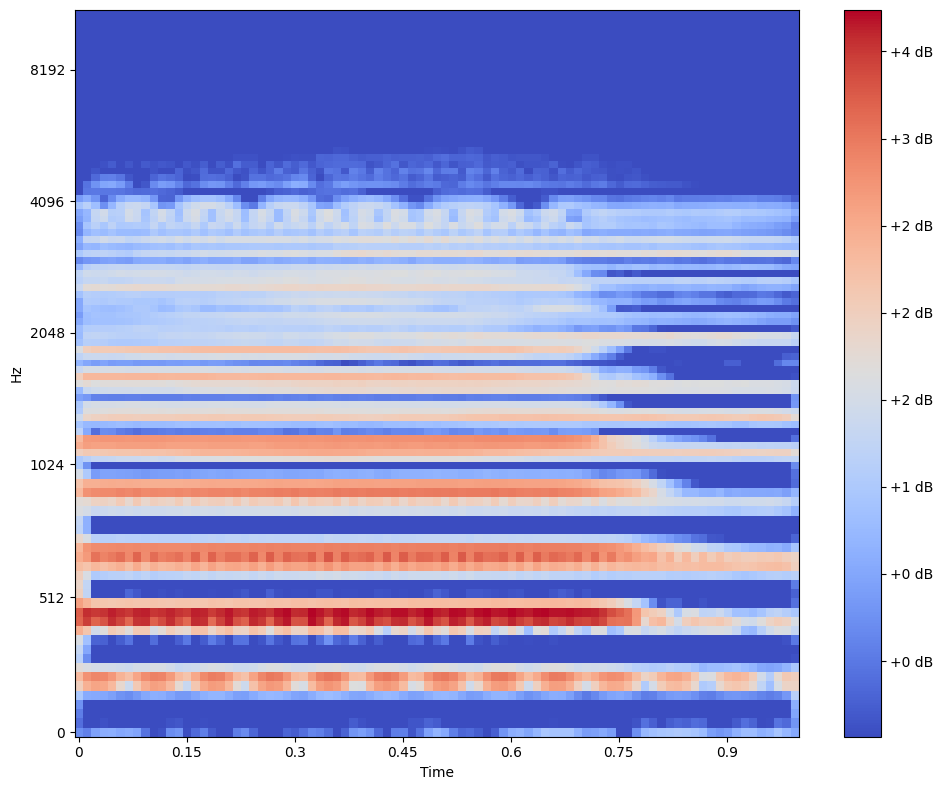

In [184]:
# Plot the Mel spectrogram and the PCEN-normalized spectrogram
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

img1 = librosa.display.specshow(
    db_data["violin/0002.wav_violin/0003.wav_data_1"],
    x_axis="time",
    y_axis="mel",
    sr=sr,
    hop_length=int(0.0116 * sr),
)

fig.colorbar(img1, format="%+2.0f dB")

plt.tight_layout()
plt.show()